# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import time
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
114504,2016-03-08 09:55:08,1400,wagon,2000,manual,150,a6,150000,8,gasoline,audi,no,2016-03-08 00:00:00,0,76149,2016-04-06 20:19:33
7903,2016-03-12 15:37:22,2999,sedan,2001,manual,143,e_klasse,150000,6,gasoline,mercedes_benz,no,2016-03-12 00:00:00,0,71032,2016-03-14 07:16:47
217126,2016-03-07 14:58:37,2100,small,2000,manual,75,a2,150000,11,petrol,audi,yes,2016-03-07 00:00:00,0,65197,2016-03-11 04:16:40
178216,2016-03-18 17:37:18,4799,NaN,2017,manual,130,mondeo,90000,4,gasoline,ford,no,2016-03-18 00:00:00,0,35216,2016-03-20 05:44:55
201327,2016-03-25 17:43:37,3800,small,2009,manual,68,aygo,70000,5,petrol,toyota,no,2016-03-25 00:00:00,0,72516,2016-03-25 17:43:37


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Из описания таблицы видно, что столбец, отвечающий за число фотографий полностью пустой. Брак? Возможно. Но в работе модели эти данные окажутся бессмысленными, а потому столбец можно удалить

In [5]:
df = df.drop('NumberOfPictures', axis=1)

Для начала переименуем столбцы:

In [6]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year',
              'gearbox', 'power', 'model', 'kilometer', 'registration_month',
              'fuel_type', 'brand', 'repaired', 'date_created', 'postal_code', 'last_seen']
df.columns.to_list()

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'postal_code',
 'last_seen']

Приведём столбцы к нужному типу:

In [7]:
df['date_crawled'] = df['date_crawled'].astype('datetime64[ns]')
df['date_created'] = df['date_created'].astype('datetime64[ns]')
df['last_seen'] = df['last_seen'].astype('datetime64[ns]')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  postal_code         354369 no

Заполним очевидные пропуски:

In [8]:
df['vehicle_type'] = df['vehicle_type'].fillna('unkwn')
df['gearbox'] = df['gearbox'].fillna('unkwn')
df['model'] = df['model'].fillna('unkwn')
df['fuel_type'] = df['fuel_type'].fillna('unkwn')
df['repaired'] = df['repaired'].fillna('unkwn')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  postal_code         354369 no

=> Все пропуски заполнены

In [10]:
def iqr_del(column):
    # вычисляем квартили, кол-во данных и IQR
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    l = len(df)

    filt_df = df[(df[column] >= q1 - 1.5 * iqr) & (df[column] <= q3 + 1.5 * iqr)]
    proc = 1 - len(filt_df) / len(df)
    if proc <= 0.01 and proc > 0:
        print(f"Размах 1.5 iqr, столбец {i}\nДанных вне размаха: {proc*100:.2f}%", end='\n\n')
        return filt_df
    else:
        filt_df = df[(df[column] >= q1 - 2.5 * iqr) & (df[column] <= q3 + 2.5 * iqr)]
        proc = 1 - len(filt_df) / len(df)
        if proc <= 0.01 and proc > 0:
            print(f"Размах 2.5 iqr, столбец {i}\nДанных вне размаха: {proc*100:.2f}%", end='\n\n')
            return filt_df
    
    return df

In [11]:
types = df.dtypes
for i in df.columns.to_list():
    if types[i] == 'int64':
        df = iqr_del(i)

df.info()

Размах 2.5 iqr, столбец price
Данных вне размаха: 0.41%

Размах 2.5 iqr, столбец registration_year
Данных вне размаха: 0.78%

Размах 2.5 iqr, столбец power
Данных вне размаха: 0.62%

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347987 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        347987 non-null  datetime64[ns]
 1   price               347987 non-null  int64         
 2   vehicle_type        347987 non-null  object        
 3   registration_year   347987 non-null  int64         
 4   gearbox             347987 non-null  object        
 5   power               347987 non-null  int64         
 6   model               347987 non-null  object        
 7   kilometer           347987 non-null  int64         
 8   registration_month  347987 non-null  int64         
 9   fuel_type           347987 non-null  object        
 10  brand            

In [12]:
plt.rcParams["figure.figsize"] = (12,8)

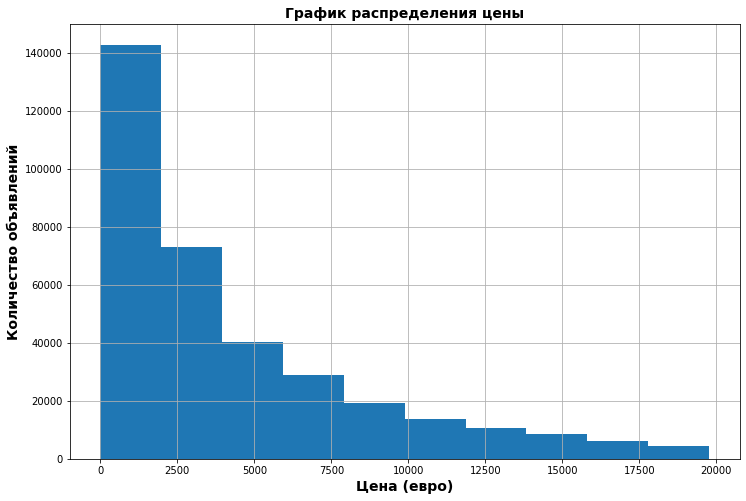

In [13]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_title('График распределения цены', fontsize=14, fontweight='bold')

ax.set_xlabel('Цена (евро)', fontsize=14, fontweight='bold')
ax.set_ylabel('Количество объявлений', fontsize=14, fontweight='bold')

_ = df.price.hist()

In [14]:
print('Количество объявлений, у которых стоимость автомобиля меньше 300:', len(df.query('price<300')))

Количество объявлений, у которых стоимость автомобиля меньше 300: 22607


In [15]:
print('Количество объявлений, у которых стоимость автомобиля меньше 500:', len(df.query('price<500')))

Количество объявлений, у которых стоимость автомобиля меньше 500: 35422


In [16]:
print('Количество объявлений, у которых стоимость автомобиля больше 20000:', len(df.query('price>20000')))

Количество объявлений, у которых стоимость автомобиля больше 20000: 0


Машины с низкой стоимостью могут нам помешать; удалим часть

In [17]:
df = df.query('price >=1000')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265497 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        265497 non-null  datetime64[ns]
 1   price               265497 non-null  int64         
 2   vehicle_type        265497 non-null  object        
 3   registration_year   265497 non-null  int64         
 4   gearbox             265497 non-null  object        
 5   power               265497 non-null  int64         
 6   model               265497 non-null  object        
 7   kilometer           265497 non-null  int64         
 8   registration_month  265497 non-null  int64         
 9   fuel_type           265497 non-null  object        
 10  brand               265497 non-null  object        
 11  repaired            265497 non-null  object        
 12  date_created        265497 non-null  datetime64[ns]
 13  postal_code         265497 no

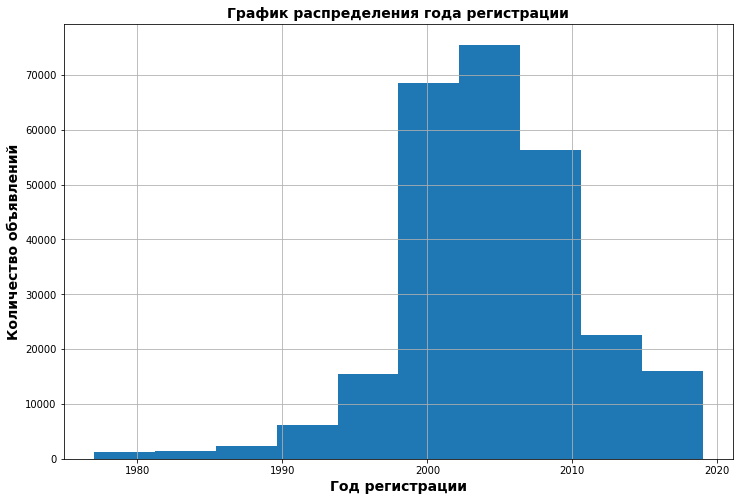

In [19]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_title('График распределения года регистрации', fontsize=14, fontweight='bold')

ax.set_xlabel('Год регистрации', fontsize=14, fontweight='bold')
ax.set_ylabel('Количество объявлений', fontsize=14, fontweight='bold')

_ = df['registration_year'].hist()

Слишком старые автомобили не так актуальны

In [20]:
df = df.query('registration_year >=1985')

In [21]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code', 'last_seen'],
      dtype='object')

In [22]:
len(df.query('date_crawled.dt.year > registration_year'))

248183

In [23]:
df = df.query('date_crawled.dt.year > registration_year')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248183 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        248183 non-null  datetime64[ns]
 1   price               248183 non-null  int64         
 2   vehicle_type        248183 non-null  object        
 3   registration_year   248183 non-null  int64         
 4   gearbox             248183 non-null  object        
 5   power               248183 non-null  int64         
 6   model               248183 non-null  object        
 7   kilometer           248183 non-null  int64         
 8   registration_month  248183 non-null  int64         
 9   fuel_type           248183 non-null  object        
 10  brand               248183 non-null  object        
 11  repaired            248183 non-null  object        
 12  date_created        248183 non-null  datetime64[ns]
 13  postal_code         248183 no

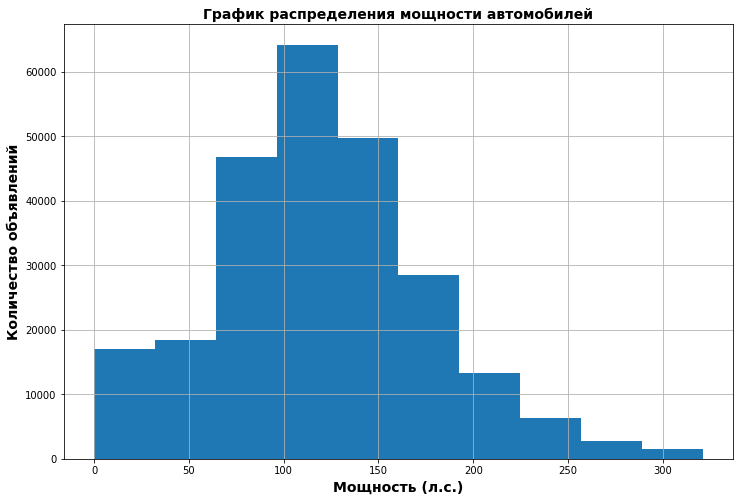

In [25]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_title('График распределения мощности автомобилей', fontsize=14, fontweight='bold')

ax.set_xlabel('Мощность (л.с.)', fontsize=14, fontweight='bold')
ax.set_ylabel('Количество объявлений', fontsize=14, fontweight='bold')

_ = df.power.hist()

Слишком медленный транспорт также может плохо продаваться

In [26]:
df = df.query('power > 30')

In [27]:
df.power.max()

321

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231237 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        231237 non-null  datetime64[ns]
 1   price               231237 non-null  int64         
 2   vehicle_type        231237 non-null  object        
 3   registration_year   231237 non-null  int64         
 4   gearbox             231237 non-null  object        
 5   power               231237 non-null  int64         
 6   model               231237 non-null  object        
 7   kilometer           231237 non-null  int64         
 8   registration_month  231237 non-null  int64         
 9   fuel_type           231237 non-null  object        
 10  brand               231237 non-null  object        
 11  repaired            231237 non-null  object        
 12  date_created        231237 non-null  datetime64[ns]
 13  postal_code         231237 no

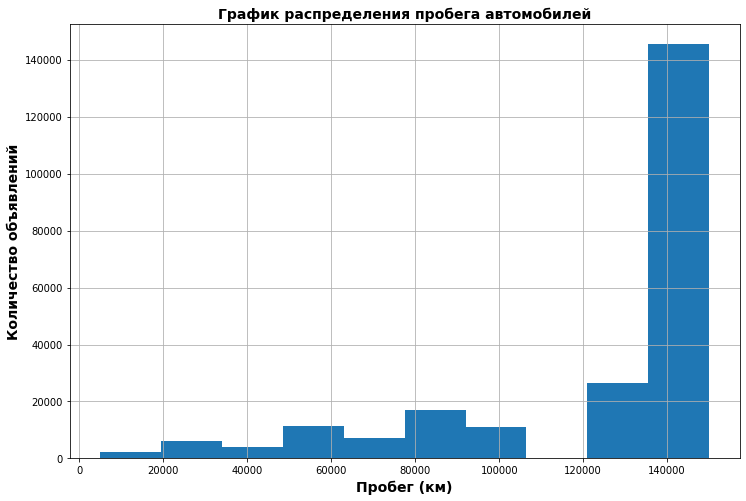

In [29]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_title('График распределения пробега автомобилей', fontsize=14, fontweight='bold')

ax.set_xlabel('Пробег (км)', fontsize=14, fontweight='bold')
ax.set_ylabel('Количество объявлений', fontsize=14, fontweight='bold')

_ = df.kilometer.hist()

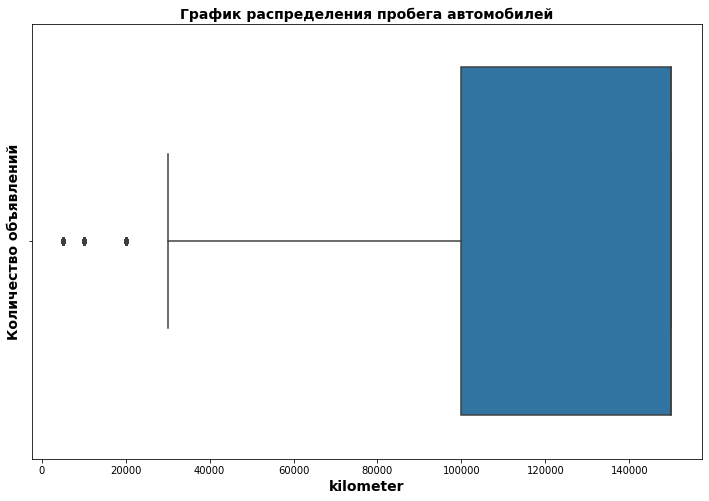

In [30]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_title('График распределения пробега автомобилей', fontsize=14, fontweight='bold')

ax.set_xlabel('Пробег (км)', fontsize=14, fontweight='bold')
ax.set_ylabel('Количество объявлений', fontsize=14, fontweight='bold')

_ = sns.boxplot(df.kilometer)

У основной массы автомобилей гигантский пробег. Тут ничего не поделаешь: новые машины больше привлекают, а использованные составляют большую часть выборки

=> Выбросы числовых данных удалены

In [31]:
columns_to_drop = [
    'postal_code',
    'date_crawled',
    'registration_month',
    'last_seen',
    'date_created',
]
df = df.drop(columns_to_drop, axis=1)

In [32]:
df.duplicated().sum()

30616

In [33]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200621 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              200621 non-null  int64 
 1   vehicle_type       200621 non-null  object
 2   registration_year  200621 non-null  int64 
 3   gearbox            200621 non-null  object
 4   power              200621 non-null  int64 
 5   model              200621 non-null  object
 6   kilometer          200621 non-null  int64 
 7   fuel_type          200621 non-null  object
 8   brand              200621 non-null  object
 9   repaired           200621 non-null  object
dtypes: int64(4), object(6)
memory usage: 16.8+ MB


**Вывод:** Предобработка завершена

## Обучение моделей

In [35]:
numbers = ['registration_year', 'power', 'kilometer']
features = df.drop('price', axis=1)
target = df['price']

features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=.2, random_state=1012)

In [36]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

In [37]:
a = []
b = []
for i in features_train.columns:
    if i not in features_test:
        a.append(i)
        
for i in features_test.columns:
    if i not in features_train:
        b.append(i)
        
display(a)
display(b)

['model_601',
 'model_charade',
 'model_elefantino',
 'model_kalina',
 'model_range_rover_evoque',
 'model_rangerover',
 'model_samara']

[]

In [38]:
features_train = features_train.drop(a, axis=1)
features_test = features_test.drop(b, axis=1)

In [39]:
scaler = StandardScaler()
scaler.fit(features_train[numbers])
pd.options.mode.chained_assignment = None

features_train[numbers] = scaler.transform(features_train[numbers])
features_test[numbers] = scaler.transform(features_test[numbers])

In [40]:
%%time

model_lr = LinearRegression()

cross_val_scores = cross_val_score(model_lr, features_train, target_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cross_val_scores)
rmse_linear = round(np.mean(rmse_scores), 2)
print('Средний RMSE на кросс-валидации:', rmse_linear)

# Обучение одной лучшей модели

fit_time_start = time.time()
model_lr.fit(features_train, target_train)
fit_time_end = time.time()

model_lr.predict(features_train)
predict_time_end = time.time()

lr_fit_time = round((fit_time_end - fit_time_start), 2)
lr_pred_time = round(predict_time_end - fit_time_end, 2)

print('Время обучения лучшей модели:', lr_fit_time)

Средний RMSE на кросс-валидации: 2285.63
Время обучения лучшей модели: 54.72
CPU times: user 2min 1s, sys: 2min 26s, total: 4min 27s
Wall time: 4min 28s


**Дерево решений**

In [41]:
def rmse(true, pred):
    return sqrt(mean_squared_error(true, pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [42]:
%%time

model_tree = DecisionTreeRegressor(random_state=1)
parametrs = {'max_depth': [None] + list(range(2, 7))}

grid_tree = GridSearchCV(model_tree, param_grid=parametrs, cv=5, scoring=rmse_scorer)

grid_tree.fit(features_train, target_train)
model_tree = grid_tree.best_estimator_
rmse_tree = round(-grid_tree.best_score_, 2)

fit_time_start = time.time()
model_tree.fit(features_train, target_train)
fit_time_end = time.time()

model_tree.predict(features_train)
predict_time_end = time.time()

tree_fit_time = round((fit_time_end - fit_time_start), 2)
tree_pred_time = round(predict_time_end - fit_time_end, 2)

print('Средний RMSE на кросс-валидации:', rmse_tree)
print('Максимальная глубина дерева наилучшей модели:', grid_tree.best_params_['max_depth'])

Средний RMSE на кросс-валидации: 1911.14
Максимальная глубина дерева наилучшей модели: None
CPU times: user 53.6 s, sys: 5.95 s, total: 59.6 s
Wall time: 59.9 s


**Случайный лес**

In [43]:
%%time
model_forest = RandomForestRegressor(random_state=1)
parametrs = {'n_estimators': [10, 50, 100],
             'max_depth': [1, 10, 20],}

grid_forest = GridSearchCV(model_forest, param_grid=parametrs, cv=5, scoring=rmse_scorer)

grid_forest.fit(features_train, target_train)
model_forest = grid_forest.best_estimator_
rmse_forest = round(-grid_forest.best_score_, 2)

fit_time_start = time.time()
model_forest.fit(features_train, target_train)
fit_time_end = time.time()

model_forest.predict(features_train)
predict_time_end = time.time()

forest_fit_time = round((fit_time_end - fit_time_start), 2)
forest_pred_time = round(predict_time_end - fit_time_end, 2)

print('RMSE работы случайного леса на обучающей выборке:', rmse_forest)
print('Максимальная глубина дерева наилучшей модели:', grid_forest.best_params_['max_depth'])
print('Количество деревьев в наилучшей модели:', grid_forest.best_params_['n_estimators'])

RMSE работы случайного леса на обучающей выборке: 1610.03
Максимальная глубина дерева наилучшей модели: 20
Количество деревьев в наилучшей модели: 100
CPU times: user 55min 32s, sys: 17.4 s, total: 55min 49s
Wall time: 55min 53s


**CatBoost**

In [44]:
features_cb = df.drop('price', axis=1)
target_cb = df['price']

features_cb_train, features_cb_test, target_cb_train, target_cb_test = train_test_split(
    features_cb, target_cb, test_size=0.2, random_state=1012)

cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [45]:
features_cb_train[cat_features] = features_cb_train[cat_features].astype('category')
features_cb_test[cat_features] = features_cb_test[cat_features].astype('category')

In [46]:
%%time
model_cb = CatBoostRegressor(silent=True, cat_features=cat_features)
grid_cb = {'depth': [6, 8, 10],
           'learning_rate': [0.01, 0.05, 0.1],
           'iterations': [200, 150]}

# Создание экземпляра GridSearchCV со стандартной кросс-валидацией
grid_search = GridSearchCV(estimator=model_cb,
                           param_grid=grid_cb,
                           cv=2,
                           n_jobs=-1,
                           scoring='neg_mean_squared_error')

# Запуск поиска сетки параметров
grid_search.fit(features_cb_train, target_cb_train)
rmse_cb = round(np.sqrt(-grid_search.best_score_), 2)

# Получение лучшей модели
best_model_cb = grid_search.best_estimator_


fit_time_start = time.time()
best_model_cb.fit(features_cb_train, target_cb_train)
fit_time_end = time.time()

best_model_cb.predict(features_cb_train)
predict_time_end = time.time()

print('RMSE работы CatBoost на тренировочной выборке:', rmse_cb)

RMSE работы CatBoost на тренировочной выборке: 1574.15
CPU times: user 14min 10s, sys: 5.3 s, total: 14min 15s
Wall time: 14min 52s


In [47]:
cb_fit_time = round(fit_time_end - fit_time_start, 2)
cb_pred_time = round(predict_time_end - fit_time_end, 2)

**LightGBM**

In [48]:
%%time
lgb_model = lgb.LGBMRegressor(random_state=1012)
parametrs = {'n_estimators': [10, 50, 100],
             'learning_rate': [0.03, 0.1],
             'max_depth': [1, 6, 10]}


grid_lgb = GridSearchCV(lgb_model, param_grid=parametrs, cv=2, scoring='neg_mean_squared_error')
grid_lgb.fit(features_cb_train, target_cb_train)

rmse_lgb = round(np.sqrt(-grid_lgb.best_score_), 2)
best_model_lgb = grid_lgb.best_estimator_

fit_time_start = time.time()
best_model_lgb.fit(features_cb_train, target_cb_train)
fit_time_end = time.time()

best_model_lgb.predict(features_cb_train)
predict_time_end = time.time()

print('Средний RMSE на кросс-валидации:', rmse_lgb)
print('Максимальная глубина дерева наилучшей модели:', grid_lgb.best_params_['max_depth'])
print('Количество деревьев в наилучшей модели:', grid_lgb.best_params_['n_estimators'])
print('Коэффициент скорости обучения в наилучшей модели:', grid_lgb.best_params_['learning_rate'])

Средний RMSE на кросс-валидации: 1570.58
Максимальная глубина дерева наилучшей модели: 10
Количество деревьев в наилучшей модели: 100
Коэффициент скорости обучения в наилучшей модели: 0.1
CPU times: user 29min 7s, sys: 28.9 s, total: 29min 36s
Wall time: 29min 44s


In [49]:
lgb_fit_time = round(fit_time_end - fit_time_start, 2)
lgb_pred_time = round(predict_time_end - fit_time_end, 2)

**Вывод:**  
На тренировочных данных лучше всего себя показала модель **случайного дерева** и модель градиентного бустинга на основе **catboost**. Они была оптимальнее других по точности и времени выполнения работы. Сравним их результаты на тестовой выборке с работой константной модели!

## Анализ моделей

In [50]:
results = pd.DataFrame({'Models':['Linear Regression', 'Decision Tree', 'Random Forest', 'CatBoost', 'LightGBM'],
                       'RMSE': [rmse_linear, rmse_tree, rmse_forest, rmse_cb, rmse_lgb],
                       'Fit time': [lr_fit_time, tree_fit_time, forest_fit_time, cb_fit_time, lgb_fit_time],
                       'Predict time': [lr_pred_time, tree_pred_time, forest_pred_time, cb_pred_time, lgb_pred_time]})

results

,Models,RMSE,Fit time,Predict time
0,Linear Regression,2285.63,54.72,0.30
1,Decision Tree,1911.14,4.77,0.34
2,Random Forest,1610.03,262.32,5.20
3,CatBoost,1574.15,84.63,0.55
4,LightGBM,1570.58,33.39,1.69


По соотношению метрика/время лучше всего справилась модель **CatBoost**. Возьмём её для дальнейшего анализа.

Обучим константную модель для сравнения эффективности:

In [51]:
%%time

model_const = DummyRegressor()
model_const.fit(features_train, target_train)
model_const_predict = model_const.predict(features_test)

model_const_rmse = (mean_squared_error(target_test, model_const_predict)**0.5).mean()
print('RMSE:', model_const_rmse)

RMSE: 4488.280915202244
CPU times: user 1.52 ms, sys: 0 ns, total: 1.52 ms
Wall time: 1.26 ms


**=>** Время - шикарное, RMSE - ужасное

In [54]:
# Работа лучшей модели на тестовой выборке

final_cb_model = grid_search.best_estimator_
final_cb_model.fit(features_cb_train, target_cb_train)

rmse_cb = rmse(target_cb_test, final_cb_model.predict(features_cb_test))

In [56]:
print("RMSE лучшей модели на тестовой выборке:", round(rmse_cb, 2))

RMSE лучшей модели на тестовой выборке: 1576.16


**Вывод:**  
В результате работы моделей мы выяснили следующие факты:
* Наша работа дала плоды, модели превзошли в эффективности оценки константную
* **Наилучшим образом** на тестовых данных показала себя модель градиентного бустинга (на основе **CatBoost**)
* RMSE наилучшей модели составило 1576, что является хорошим показателем

In [ ]:
model_tree = DecisionTreeRegressor(random_state=1, max_depth=None)
model_tree.fit(features_train, target_train)
print(rmse(target_test, model_tree.predict(features_test)))